<a href="https://colab.research.google.com/github/mansoorshakeel0-stack/Project/blob/main/Emotion%20Recognition%20from%20Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTALL NECESSARY LIBRARIES

In [15]:
!pip install -q librosa soundfile tensorflow scikit-learn matplotlib seaborn

Imports Libraries

In [16]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models

Data path

In [31]:
DATA_PATH = "/content/EMODB_Audio/EMODB_Audio/wav/"   # or "/content/EMODB_Audio/"

n_mfcc = 40
max_len = 150   # Fixed number of MFCC frames
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

List all audio files

In [32]:
wav_files = [os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH) if f.endswith(".wav")]
print(f"Total audio files found: {len(wav_files)}")




Total audio files found: 535


Map emotion codes from filenames

In [33]:
emotion_map = {
    "W": "anger",
    "L": "boredom",
    "E": "disgust",
    "A": "fear",
    "F": "happy",
    "T": "sad",
    "N": "neutral"
}

def get_emotion_from_filename(fname):
    if len(fname) >= 6:
        return emotion_map.get(fname[5], "unknown")
    return "unknown"

MFCC feature extraction

In [34]:
def extract_mfcc(file_path, n_mfcc=n_mfcc, max_len=max_len, sr=16000):
    y, _ = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-9)
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0,0),(0, max_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc


Build dataset

In [35]:
X, y = [], []
for f in wav_files:
    label = get_emotion_from_filename(os.path.basename(f))
    if label != "unknown":
        mfcc = extract_mfcc(f)
        X.append(mfcc)
        y.append(label)

X = np.array(X)[..., np.newaxis]  # (samples, n_mfcc, max_len, 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = tf.keras.utils.to_categorical(y_encoded)
print("Data shape:", X.shape, "Labels:", le.classes_)

Data shape: (535, 40, 150, 1) Labels: ['anger' 'boredom' 'disgust' 'fear' 'happy' 'neutral' 'sad']


Train/test split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.25, stratify=y_encoded, random_state=SEED)

CNN model

In [37]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 150, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 150, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,815 (93.03 KB)

 Trainable params: 23,623 (92.28 KB)

 Non-trainable params: 192 (768.00 B)

Training model

In [38]:
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)]
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - accuracy: 0.2484 - loss: 1.9375 - val_accuracy: 0.2131 - val_loss: 1.9403
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.3003 - loss: 1.7604 - val_accuracy: 0.1311 - val_loss: 1.9417
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.4123 - loss: 1.6350 - val_accuracy: 0.1148 - val_loss: 1.9444
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.4095 - loss: 1.5165 - val_accuracy: 0.1148 - val_loss: 1.9491
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.3815 - loss: 1.4375 - val_accuracy: 0.1148 - val_loss: 1.9493
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.4635 - loss: 1.3369 - val_accuracy: 0.1148 - val_loss: 1.9473
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.4481 - loss: 1.3454 - val_accuracy: 0.1148 - val_loss: 1.9530


Plot training curves

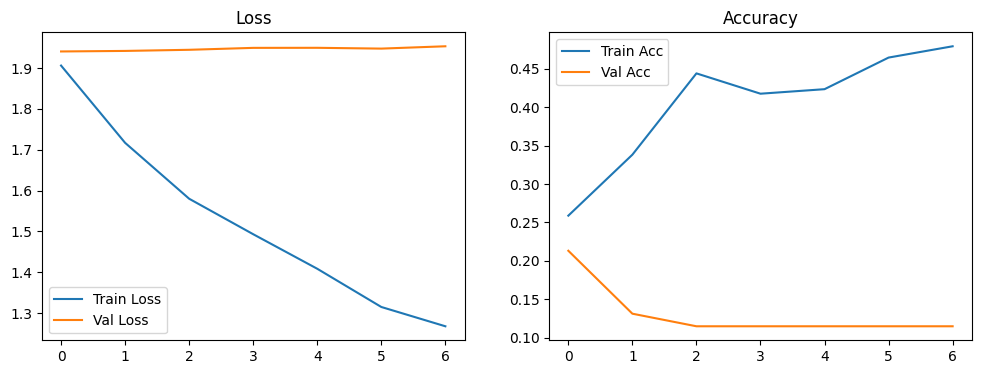

In [39]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")
plt.show()

Evaluation

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step

Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        32
     boredom       0.00      0.00      0.00        20
     disgust       0.50      0.09      0.15        11
        fear       0.00      0.00      0.00        17
       happy       0.27      0.72      0.39        18
     neutral       0.00      0.00      0.00        20
         sad       0.19      1.00      0.32        16

    accuracy                           0.22       134
   macro avg       0.14      0.26      0.12       134
weighted avg       0.10      0.22      0.10       134



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


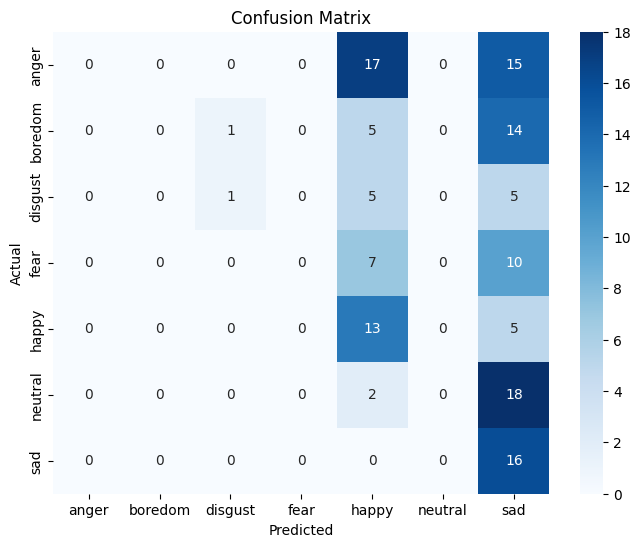

In [40]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()


ROC-AUC

In [41]:
try:
    roc = roc_auc_score(y_test, model.predict(X_test), average='macro', multi_class='ovr')
    print("ROC-AUC (macro):", roc)
except Exception as e:
    print("ROC-AUC skipped:", e)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
ROC-AUC (macro): 0.6807666640525303
